In [226]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt


In [227]:
df = pd.read_pickle("../output/scalability_data/mc_horizontal_scalability_data.pickle")
df

,FORECASTER,POD_COUNT,RPS,RESPONSE_TIMES
0,MarkovChain,1,20,"[0.11233558235168457, 0.1864699321746826, 0.31..."
1,MarkovChain,2,40,"[0.010961433029174805, 0.011078973388671875, 0..."
2,MarkovChain,3,60,"[0.01241483268737793, 0.010948320007324219, 0...."
3,MarkovChain,4,80,"[0.011972566223144531, 0.01216163215637207, 0...."
4,MarkovChain,5,100,"[0.011634965515136719, 0.013297935104370117, 0..."


/home/ubuntu/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/ubuntu/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{1: [[0.0, nan, nan, 0.0, nan, nan], [0.0, nan, nan, 0.0, nan, nan], [16.623755073547365, 16.10135312486656, 17.090891595592428, 46.76637229919434, 43.18054356869212, 48.49954180423266], [18.423934555053712, 16.848128997056993, 21.038768280775038, 389.68641099929806, -205.9406554749223, 832.8293189575882], [20.629187202453615, 20.003103405095914, 21.461836856744906, 46.82466802597046, 40.504591968219735, 50.43592374070357], [11.140366172790527, 10.854610194910109, 11.420447788488332, 22.168732261657713, 15.66341107603135, 25.39892985109265], [11.734624481201172, 11.558266753142783, 11.938781815582804, 26.001670932769773, 21.589374185588316, 28.778020452473164], [13.023396110534668, 12.710912745393209, 13.34222140988023, 30.79877910614013, 27.143676024720016, 33.58217522497477]], 2: [[0.0, nan, nan, 0.0, nan, nan], [0.0, nan, nan, 0.0, nan, nan], [16.459007835388185, 16.196678107932275, 16.70650792722398, 52.80427989959717, 44.73117676527269, 55.52771357743967], [17.849345779418947, 16.

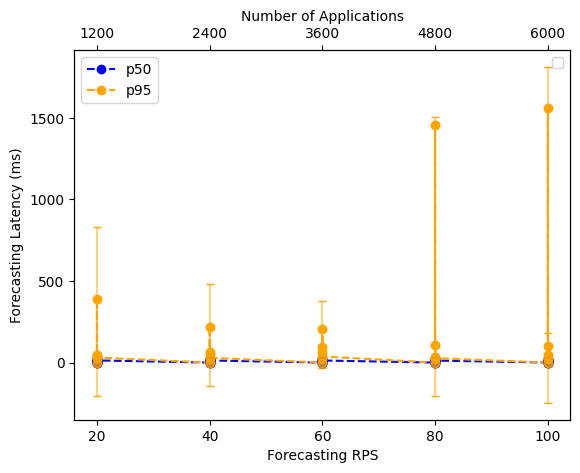

In [272]:
legend_elements = []
all_rps = {1: 20, 2: 40, 3: 60, 4: 80, 5: 100}

pod_count_response_times = {}
colors = {1: "blue", 2: "orange", 3: "green", 4: "red", 5: "purple"}

fig, ax1 = plt.subplots()

for _, row in df.iterrows():
    forecaster_count = row["POD_COUNT"]
    response_times = row["RESPONSE_TIMES"][-1000:]
    rps = int(row["RPS"])
    # all_rps.add(rps)
    median_response_time_per_iter = np.median(response_times)
    avg_response_time_per_iter = np.mean(response_times)
    p95_response_time_per_iter = np.percentile(response_times, 99)

    chunked_p95_times = []
    chunked_med_times = []

    chunk_size = 200

    for i in range(0, len(response_times), chunk_size):
        chunked_p95_times.append(np.percentile(response_times[i:i+chunk_size], 99))
        chunked_med_times.append(np.median(response_times[i:i+chunk_size]))
    
    mean_p95 = np.mean(chunked_p95_times)
    sem_p95 = stats.sem(chunked_p95_times)
    confidence = 0.95

    confidence_interval_for_p95 = stats.t.interval(confidence, len(chunked_p95_times)-1, loc=mean_p95, scale=sem_p95)

    mean_med = np.mean(chunked_med_times)
    sem_med = stats.sem(chunked_med_times)

    confidence_interval_for_median = stats.t.interval(confidence, len(chunked_med_times)-1, loc=mean_med, scale=sem_med)
    
    if forecaster_count not in pod_count_response_times:
        pod_count_response_times[forecaster_count] = []
    pod_count_response_times[forecaster_count].append([median_response_time_per_iter*1000, 
                                                       confidence_interval_for_median[0]*1000, 
                                                       confidence_interval_for_median[1]*1000, 
                                                       p95_response_time_per_iter*1000,
                                                       confidence_interval_for_p95[0]*1000, 
                                                       confidence_interval_for_p95[1]*1000])
print(pod_count_response_times)
cur_rps = []
cur_resp_med = []
cur_lci_med = []
cur_uci_med = []

cur_resp_p95 = []
cur_lci_p95 = []
cur_uci_p95 = []
for count, response_times_and_ci in pod_count_response_times.items():

    for resp_med, lci_med, uci_med, resp_p95, lci_p95, uci_p95 in response_times_and_ci:
        cur_rps.append(all_rps[count])
        cur_lci_med.append(lci_med)
        cur_uci_med.append(uci_med)
        cur_resp_med.append(resp_med)

        cur_lci_p95.append(lci_p95)
        cur_uci_p95.append(uci_p95)
        cur_resp_p95.append(resp_p95)

ax1.plot(cur_rps, cur_resp_med, 'o--', label="p50", color="blue")
ax1.plot(cur_rps, cur_resp_p95, 'o--', label="p95", color="orange")
print(cur_rps, cur_resp_med)
# plot the confidence intervals as vertical lines
ax1.errorbar(cur_rps, cur_resp_med, yerr=[np.array(cur_resp_med)-np.array(cur_lci_med), np.array(cur_uci_med)-np.array(cur_resp_med)], fmt='o', color="blue",  alpha=0.5)
ax1.errorbar(cur_rps, cur_resp_p95, yerr=[np.array(cur_resp_p95)-np.array(cur_lci_p95), np.array(cur_uci_p95)-np.array(cur_resp_p95)], fmt='o', color="orange",  alpha=0.5)
# print(np.array(cur_resp_med)-np.array(cur_lci_med), np.array(cur_uci_med)-np.array(cur_resp_med))
ax1.plot(cur_rps, cur_lci_med, '_', color="blue")
ax1.plot(cur_rps, cur_uci_med, '_', color="blue")

ax1.plot(cur_rps, cur_lci_p95, '_', color="orange")
ax1.plot(cur_rps, cur_uci_p95, '_', color="orange")

ax1.set_xticks(list(all_rps.values()))

ax1.set_xlabel("Forecasting RPS")
ax1.set_ylabel("Forecasting Latency (ms)")

# create a second x-axis at the top of the plot
ax2 = ax1.twiny()

# calculate the new x-values for the top x-axis
new_xticks = [value*60 for value in all_rps.values()]
new_xticklabels = [value for value in all_rps.values()]

# set the xticks and xticklabels for the top x-axis
ax2.set_xticks(new_xticks)
ax2.set_xticklabels(new_xticks)
ax2.set_xlabel("Number of Applications")

# calculate the padding for the x-axis limits
padding = (max(all_rps.values()) - min(all_rps.values())) * 0.05

# set the limits of both axes to be the same with padding
ax1.set_xlim([min(all_rps.values()) - padding, max(all_rps.values()) + padding])
ax2.set_xlim([min(new_xticks) - padding*60, max(new_xticks) + padding*60])
ax1.legend()
ax2.legend()
# plt.legend()
plt.show()
fig.savefig("../output/scalability_data/hsp.pdf")


In [202]:
# # create dummy forecasting data to maintain continuity
# dummy_forecasting_data_5 = pd.DataFrame({"FORECASTER": ["5"]*5 ,	
#                                          "POD_COUNT": [i for i in range(1, 6)],
#                                          "RPS": [i*20 for i in range(1, 6)],
#                                         "RESPONSE_TIMES": [[0]*5000]*5})
# dummy_forecasting_data_1 = pd.DataFrame({"FORECASTER": ["1"]*5 ,	
#                                          "POD_COUNT": [i for i in range(1, 6)],
#                                          "RPS": [i*20 for i in range(1, 6)],
#                                         "RESPONSE_TIMES": [[0]*5000]*5})
# dummy_forecasting_data_5.to_pickle("../output/per_forecaster_data/5_horizontal_scalability_data.pickle")
# dummy_forecasting_data_1.to_pickle("../output/per_forecaster_data/10_horizontal_scalability_data.pickle")

In [277]:
# weight_map = {'S': 22, 'A': 22, 'H': 1, 'E': 8, 'M': 534, '1': 15, '5': 393, 'F': 2}
weight_map = {'S': 22, 'A': 22, 'H': 1, 'E': 8, 'M': 534, '1': 15, '5': 393, 'F': 2}

In [278]:
# combine all dataframes in per_forecaster_data folder
df = pd.DataFrame()
# forecasters = ["5", "10", "ar", "es", "holt", "mc", "setar", "fft"]
forecasters = ["5", "10", "ar", "es", "holt", "mc", "setar", "fft"]
for i in range(len(forecasters)):
    df = pd.concat([df, pd.read_pickle(f"../output/per_forecaster_data_v2/{forecasters[i]}_horizontal_scalability_data.pickle")], ignore_index=True)
df

,FORECASTER,POD_COUNT,RPS,RESPONSE_TIMES
0,5,1,20,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,5,2,40,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,5,3,60,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,5,4,80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,5,100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,1,1,20,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,1,2,40,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,1,3,60,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,1,4,80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,1,5,100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


2000
2000
2000
2000
2000
997 997
997 997
997 997
997 997
997 997


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


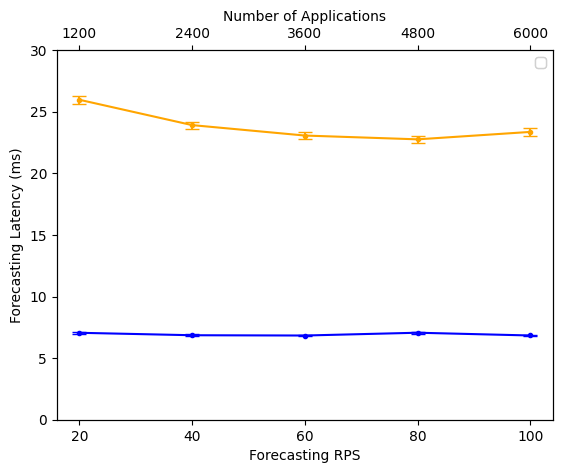

In [323]:
# inference latency
latency_map = {}
buckets = [20, 40, 60, 80, 100]
median_latency = {}
mean_latency = {}
nn_latency = {}
median_latency_ci = {}
nn_latency_ci = {}

fig, ax1 = plt.subplots()

for _, row in df.iterrows():
    # for bucket in buckets:
    apps = row["FORECASTER"][0] + "_" + str(row["RPS"])
    if apps not in latency_map:
        latency_map[apps] = []
    if "1" == apps[0] or "5" == apps[0]:
        latency_map[apps].extend([0]*len(row["RESPONSE_TIMES"][-1000:]))
    else:
        latency_map[apps].extend(row["RESPONSE_TIMES"][-1000:])
for key, val in latency_map.items():
        latency_map[key] = val * weight_map[key.split("_")[0]]
        if "F" in key:
            print(len(latency_map[key]))

cur_uci_med = []
cur_lci_med = []
cur_resp_med = []

cur_uci_p95 = []
cur_lci_p95 = []
cur_resp_p95 = []
overall_median_latency = {}
overall_nn_latency = {}

for bucket in buckets:
    same_bucket_list = []
    for key, val in latency_map.items():
        if f"{bucket}" in key:
            same_bucket_list += val

    # shuffle same_bucket_list to avoid any ordering bias and again get the list
    same_bucket_list.sort()
    same_bucket_list = np.random.permutation(same_bucket_list).tolist()

    chunked_p95_times = []
    chunked_med_times = []

    chunk_size = 1000

    for i in range(0, len(same_bucket_list), chunk_size):
        chunked_p95_times.append(np.percentile(same_bucket_list[i:i+chunk_size], 99))
        chunked_med_times.append(np.median(same_bucket_list[i:i+chunk_size]))

    print(len(chunked_med_times), len(chunked_p95_times))
    median = np.mean(chunked_med_times)
    median_latency[bucket] = median
    overall_median_latency[bucket] = np.mean(same_bucket_list)

    # mean_latency[bucket] = np.mean(same_bucket_list)
    nn = np.percentile([elem for elem in chunked_p95_times if elem != None], 99)
    nn_latency[bucket] = nn
    overall_nn_latency[bucket] = np.percentile(same_bucket_list, 99)

    # Calculate the standard error of the mean
    sem_p95 = stats.sem(chunked_p95_times)
    sem_med = stats.sem(chunked_med_times)

    # Calculate the confidence intervals
    ci_med = stats.t.interval(0.95, len(chunked_med_times)-1, loc=np.median(same_bucket_list), scale=sem_med)
    median_latency_ci[bucket] = ci_med
    cur_uci_med.append(ci_med[1]*1000)
    cur_lci_med.append(ci_med[0]*1000)
    cur_resp_med.append(median*1000)

    ci_nn = stats.t.interval(0.95, len(chunked_p95_times)-1, loc=np.percentile(same_bucket_list, 99), scale=sem_p95)
    nn_latency_ci[bucket] = ci_nn
    cur_uci_p95.append(ci_nn[1]*1000)
    cur_lci_p95.append(ci_nn[0]*1000)
    cur_resp_p95.append(nn*1000)

# Add error bars to the plot
ax1.errorbar(buckets, [overall_median_latency[bucket] * 1000 for bucket in buckets], 
             yerr=[((upper-lower) * 1000) for lower, upper in median_latency_ci.values()], 
             marker='.', capsize=5, color='blue')

ax1.errorbar(buckets, [overall_nn_latency[bucket] * 1000 for bucket in buckets], 
             yerr=[((upper-lower) * 1000) for lower, upper in nn_latency_ci.values()],
             marker='.', capsize=5, color='orange')

ax1.set_xlabel("Forecasting RPS")
ax1.set_ylabel("Forecasting Latency (ms)")

ax1.set_xticks(buckets)
ax1.set_xticklabels(buckets)


# create a second x-axis at the top of the plot
ax2 = ax1.twiny()

# calculate the new x-values for the top x-axis
new_xticks = [value*60 for value in buckets]
new_xticklabels = [value for value in buckets]

# set the xticks and xticklabels for the top x-axis
ax2.set_xticks(new_xticks)
ax2.set_xticklabels(new_xticks)
ax2.set_xlabel("Number of Applications")

# calculate the padding for the x-axis limits
padding = (max(buckets) - min(buckets)) * 0.05

# set the limits of both axes to be the same with padding
ax1.set_xlim([min(buckets) - padding, max(buckets) + padding])
ax2.set_xlim([min(new_xticks) - padding*60, max(new_xticks) + padding*60])
ax1.legend()
ax2.legend()

ax1.set_ylim([0, 30])

fig.savefig("../output/scalability_data/hsp_inference_latency.pdf")